# 2km temp and precip preprocessing

This notebook contains code for preprocessing the 2km IEM temperature and precip data in SNAP's holdings for ingest into Rasdaman. It currently clips GeoTIFFs to the IEM extent and writes them to a new folder.

The raster data of interest live in CKAN at:
- `Base/AK_CAN_2km/projected/AR5_CMIP5_models/Projected_Monthy_and_Derived_Temperature_Products_2km_CMIP5_AR5/derived`
- `Base/AK_CAN_2km/projected/AR5_CMIP5_models/Projected_Monthy_and_Derived_Precipitation_Products_2km_CMIP5_AR5/derived`
- `Base/AK_CAN_2km/historical/CRU_TS/Historical_Monthly_and_Derived_Precipitation_Products_2km_CRU_TS`
- `Base/AK_CAN_2km/historical/CRU_TS/Historical_Monthly_and_Derived_Temperature_Products_2km_CRU_TS`

The shapefile for the IEM domain is found at `/workspace/Shared/Tech_Projects/Alaska_IEM/project_data/IEM_Domain.zip`

The AR5 and CRU TS GeoTIFFs can be set up in whatever folder structure is desired, the clipping is performed in batches of whatever is in the source directory (`src_dir`), and will be written to a single output folder with the name of that directory plus `_iem_domain`. Only the `$SCRATCH_DIR` variable needs to be set, and this assumes that all possible `src_dir`s will be in `$SCRATCH_DIR`.

Clipped files are written to `$SCRATCH_DIR/<src_dir>_iem_domain/`.

In [10]:
import os
import matplotlib.pyplot as plt
from multiprocessing import Pool
from pathlib import Path
import geopandas as gpd
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from tqdm.notebook import tqdm


scratch_dir = Path(os.getenv("SCRATCH_DIR"))

In [4]:
# get extent of clipped raster using a sample FP
# because using the crop=True argument of 
# rasterio.warp.warp does not crop all of the way.

# IEM domain
# copied from /workspace/Shared/Tech_Projects/Alaska_IEM/project_data/IEM_Domain.zip
aiem_domain_gdf = gpd.read_file(scratch_dir.joinpath("shapefiles/AIEM_domain.shp"))

fp = list(scratch_dir.joinpath("ar5_2km_tas_decadal_monthly").glob("*.tif"))[0]

with rio.open(fp) as src:
    arr, transform = mask(src, aiem_domain_gdf.geometry)
arr = arr[0]
n, p = arr.shape
nodata = src.meta["nodata"]
row_idx = np.arange(n)
for i in row_idx:
    if not np.all(arr[i] == nodata):
        nb = i
        break
for i in reversed(row_idx):
    if not np.all(arr[i] == nodata):
        sb = i
        break
col_idx = np.arange(p)     
for i in col_idx:
    if not np.all(arr[:,i] == nodata):
        wb = i
        break
for i in reversed(col_idx):
    if not np.all(arr[:,i] == nodata):
        eb = i
        break
        
bounds = {"wb": wb, "sb": sb, "eb": eb, "nb": nb}

In [11]:
def clip_raster(args):
    """Clip a raster to clip_poly, crop to extent, 
    and write to out_dir with same filename
    """
    in_fp, clip_poly, bounds, out_dir = args
    with rio.open(in_fp) as src:
        arr, new_transform = mask(src, clip_poly)
        meta = src.meta.copy()
    arr = arr[0][bounds["nb"]:bounds["sb"], bounds["wb"]:bounds["eb"]]
    out_fp = out_dir.joinpath(in_fp.name.replace(".tif", "_iem_domain.tif"))
    meta["transform"] = new_transform
    with rio.open(out_fp, "w", **meta) as dst:
        dst.write(arr, 1)
        
    return out_fp


def clip_iem_rasters(src_dir, clip_poly, bounds, ncpus=32):
    """Supply the path to directory containing the GeoTIFFs to be clipped"""
    fps = src_dir.glob("*.tif")
    out_dir = Path(f"{str(src_dir)}_iem_domain")
    out_dir.mkdir(exist_ok=True)
    
    args = [(fp, clip_poly, bounds, out_dir) for fp in fps]
    out_fps = []
    # trying tqdm for progress bar
    with Pool(ncpus) as pool:
        for out in tqdm(pool.imap(clip_raster, args), total=len(args)):
            out_fps.append(out)

    print(f"All IEM rasters clipped and written to {out_dir}")
    
    return out_fps
    

def plot_sample_tif(fp):
    with rio.open(fp) as src:
        arr = src.read(1)
        arr[arr == src.meta["nodata"]] = np.nan
        plt.imshow(arr, interpolation="none")

## Monthly ingest

In [12]:
src_dir = scratch_dir.joinpath("ar5_2km_tas_decadal_monthly")
out_tas_fps = clip_iem_rasters(src_dir, aiem_domain_gdf.geometry, bounds)

  0%|          | 0/972 [00:00<?, ?it/s]

All IEM rasters clipped and written to /atlas_scratch/kmredilla/iem-webapp/ar5_2km_tas_decadal_monthly_iem_domain


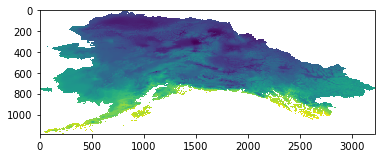

In [2]:
try:
    print(out_tas_fps[0])
except NameError:
    out_tas_fps = list(scratch_dir.joinpath("ar5_2km_tas_decadal_monthly_iem_domain").glob("*.tif"))
    
plot_sample_tif(out_tas_fps[0])

In [14]:
src_dir = scratch_dir.joinpath("ar5_2km_pr_decadal_monthly")
out_pr_fps = clip_iem_rasters(src_dir, aiem_domain_gdf.geometry, bounds)

  0%|          | 0/972 [00:00<?, ?it/s]

All IEM rasters clipped and written to /atlas_scratch/kmredilla/iem-webapp/ar5_2km_pr_decadal_monthly_iem_domain


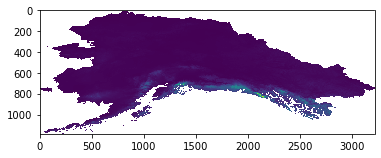

In [3]:
try:
    print(out_pr_fps[0])
except NameError:
    out_pr_fps = list(scratch_dir.joinpath("ar5_2km_pr_decadal_monthly_iem_domain").glob("*.tif"))
    
plot_sample_tif(out_pr_fps[0])

In [37]:
src_dir = scratch_dir.joinpath("cru_2km_decadal_monthly")
out_cru_fps = clip_iem_rasters(src_dir, aiem_domain_gdf.geometry, bounds)

  0%|          | 0/240 [00:00<?, ?it/s]

All IEM rasters clipped and written to /atlas_scratch/kmredilla/iem-webapp/cru_2km_decadal_monthly_iem_domain


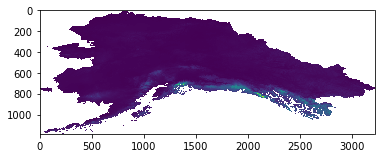

In [4]:
try:
    print(out_cru_fps[0])
except NameError:
    out_cru_fps = list(scratch_dir.joinpath("cru_2km_decadal_monthly_iem_domain").glob("*.tif"))

plot_sample_tif(out_cru_fps[0])

## Seasonal ingest

In [6]:
src_fn = "ar5_2km_pr_decadal_seasonal"
src_dir = scratch_dir.joinpath(src_fn)
ar5_seasonal_pr_fps = clip_iem_rasters(src_dir, aiem_domain_gdf.geometry, bounds)

  0%|          | 0/324 [00:00<?, ?it/s]

All IEM rasters clipped and written to /atlas_scratch/kmredilla/iem-webapp/ar5_2km_pr_decadal_seasonal_iem_domain


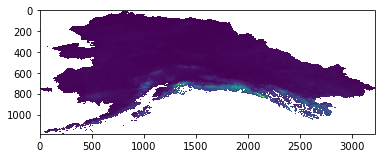

In [16]:
src_fn = "ar5_2km_pr_decadal_seasonal"

try:
    print(ar5_seasonal_pr_fps[0])
except NameError:
    ar5_seasonal_pr_fps = list(scratch_dir.joinpath(src_fn + "_iem_domain").glob("*.tif"))

plot_sample_tif(ar5_seasonal_pr_fps[0])

In [7]:
src_fn = "ar5_2km_tas_decadal_seasonal"
src_dir = scratch_dir.joinpath(src_fn)
ar5_seasonal_tas_fps = clip_iem_rasters(src_dir, aiem_domain_gdf.geometry, bounds)

  0%|          | 0/324 [00:00<?, ?it/s]

All IEM rasters clipped and written to /atlas_scratch/kmredilla/iem-webapp/ar5_2km_tas_decadal_seasonal_iem_domain


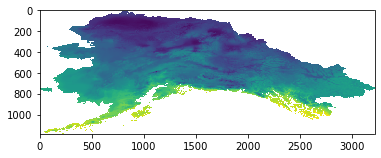

In [17]:
src_fn = "ar5_2km_tas_decadal_seasonal"

try:
    print(ar5_seasonal_tas_fps[0])
except NameError:
    ar5_seasonal_tas_fps = list(scratch_dir.joinpath(src_fn + "_iem_domain").glob("*.tif"))

plot_sample_tif(ar5_seasonal_tas_fps[0])

In [22]:
src_fn = "cru_2km_decadal_seasonal"
src_dir = scratch_dir.joinpath(src_fn)
cru_seasonal_fps = clip_iem_rasters(src_dir, aiem_domain_gdf.geometry, bounds)

  0%|          | 0/80 [00:00<?, ?it/s]

All IEM rasters clipped and written to /atlas_scratch/kmredilla/iem-webapp/cru_2km_decadal_seasonal_iem_domain


/atlas_scratch/kmredilla/iem-webapp/cru_2km_decadal_seasonal_iem_domain/pr_decadal_mean_DJF_total_mm_cru_TS31_historical_1920_1929_iem_domain.tif


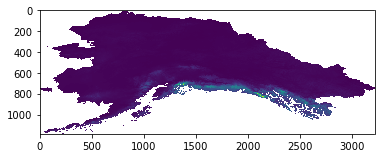

In [23]:
src_fn = "cru_2km_decadal_seasonal"

try:
    print(cru_seasonal_fps[0])
except NameError:
    cru_seasonal_fps = list(scratch_dir.joinpath(src_fn + "_iem_domain").glob("*.tif"))

plot_sample_tif(cru_seasonal_fps[0])

## Quality check

Verify that extracted values from Rasdaman ingest match some manually extracted values.

In [39]:
def extract_point(x, y, varname, model, scenario, month, decade):
    with rio.open(list(scratch_dir.joinpath("ar5_2km_pr_decadal_monthly_iem_domain").glob(f"{varname}*{model}_{scenario}_{month}_{decade}*"))[0]) as src:
        r, c = src.index(x, y)
        print(src.read(1, window=((r, r + 1), (c, c + 1)))[0,0])

In [40]:
# test point #1
# X = -2173223.206087799
# Y = 176412.932644147
# var: pr, decade: 2010-2019, month: 01, model: 5modelavg, scenario: rcp45, 
# value = -3.4e38

x = -2173223.206087799
y = 176413
varname = "pr"
model = "5modelAvg"
scenario = "rcp45"
month = "01"
decade = "2010_2019"

extract_point(x, y, varname, model, scenario, month, decade)

-3.4e+38


In [41]:
# test point #2
# X = 1000000
# Y = 1500000
# var: pr, decade: 2010-2019, month: 01, model: 5modelavg, scenario: rcp45, 
# value = 13

x = 1000000
y = 1500000
varname = "pr"
model = "5modelAvg"
scenario = "rcp45"
month = "01"
decade = "2010_2019"

extract_point(x, y, varname, model, scenario, month, decade)

13.0


In [42]:
# test point #3
# X = 1000000
# Y = 1500000
# var: pr, decade: 2020-2029, month: 03, model: 5modelavg, scenario: rcp45, 
# value = 6

x = 1000000
y = 1500000
varname = "pr"
model = "5modelAvg"
scenario = "rcp45"
month = "03"
decade = "2020_2029"

with rio.open(list(scratch_dir.joinpath("ar5_2km_pr_decadal_monthly_iem_domain").glob(f"{varname}*{model}_{scenario}_{month}_{decade}*"))[0]) as src:
    r, c = src.index(x, y)
    value = src.read(1, window=((r, r + 1), (c, c + 1)))[0,0]
    
print(value)

6.0
